<a href="https://colab.research.google.com/github/AgatElite/book-clustering-analysis/blob/main/Project_7_Stream_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
# Install kaggle library
!pip install -q kaggle

import os
from google.colab import files

print("Please upload your kaggle.json file for authentication.")
# Upload the kaggle.json file
uploaded = files.upload()

# Move the file to the correct location
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  # specific kaggle folder setup
  !mkdir -p ~/.kaggle/
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

Please upload your kaggle.json file for authentication.


Saving kaggle.json to kaggle (7).json
User uploaded file "kaggle (7).json" with length 65 bytes


In [44]:
# Download the dataset
# Note: This matches the dataset link provided in the project description
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews
!unzip -o amazon-books-reviews.zip

import csv
import math
import hashlib
import random
import statistics
import sys

# --- CONFIGURATION ---
# Set to True to process only a small portion (useful for debugging/testing code)
# Set to False to process the stream "for real"
DEBUG_MODE = False
DEBUG_LIMIT = 50000

# Dataset filename
DATA_FILE = 'Books_rating.csv'

print("Dataset downloaded and ready.")

Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
amazon-books-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  amazon-books-reviews.zip
  inflating: Books_rating.csv        
  inflating: books_data.csv          
Dataset downloaded and ready.


In [45]:
def get_stream(filename, limit=None):
    """
    Generator that simulates a stream of data from the CSV file.
    Yields one row at a time.
    """
    with open(filename, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        count = 0
        for row in reader:
            # We are interested in User_id for our stream analysis
            user_id = row['User_id']
            if user_id: # ensure it's not empty
                yield user_id
                count += 1
                if limit and count >= limit:
                    break

def distinct_hash(s, index):
    """
    Creates a family of hash functions using md5 and a salt (index).
    Returns an integer.
    """
    # We combine the string and the index to create independent hash functions
    combined = f"{s}-{index}"
    # Use md5 for better distribution than standard hash()
    hex_digest = hashlib.md5(combined.encode('utf-8')).hexdigest()
    # Convert hex to int
    return int(hex_digest, 16)

def trailing_zeros(n):
    """
    Counts the number of trailing zeros in the binary representation of n.
    Essential for Flajolet-Martin.
    """
    if n == 0: return 0
    s = bin(n)
    # Count zeros from the right end
    count = 0
    for char in reversed(s):
        if char == '0':
            count += 1
        else:
            break
    return count

In [46]:
class FlajoletMartin:
    def __init__(self, num_groups=5, hashes_per_group=4):
        """
        Implementation of FM algorithm to estimate distinct elements (F0).
        Uses median-of-averages to improve accuracy.
        """
        self.num_groups = num_groups
        self.hashes_per_group = hashes_per_group

        # R_matrix stores the max trailing zeros for each hash function
        # Structure: [group_0, group_1, ... ] where each group is a list of R values
        self.R_matrix = [[0] * hashes_per_group for _ in range(num_groups)]

    def process(self, item):
        """
        Process a single item from the stream.
        """
        for i in range(self.num_groups):
            for j in range(self.hashes_per_group):
                # Unique index for the hash function
                func_index = i * self.hashes_per_group + j

                # Get hash value
                h_val = distinct_hash(item, func_index)

                # Count trailing zeros (r(x))
                r = trailing_zeros(h_val)

                # Maintain global variable R = max(R, r(x))
                if r > self.R_matrix[i][j]:
                    self.R_matrix[i][j] = r

    def estimate(self):
        """
        Returns the estimate of distinct elements.
        Estimate ~ 2^R
        """
        group_averages = []

        for group in self.R_matrix:
            # Calculate 2^R for each hash in the group
            estimates = [2**r for r in group]
            # Take the Average within the group
            group_avg = statistics.mean(estimates)
            group_averages.append(group_avg)

        # Take the Median of the group averages to eliminate outliers
        final_estimate = statistics.median(group_averages)
        return int(final_estimate)

In [47]:
class AMS_Estimator:
    def __init__(self, num_variables=100):
        """
        Implementation of AMS Algorithm to estimate Second Moment (F2).
        Uses Reservoir Sampling to handle infinite streams.
        """
        self.num_variables = num_variables
        # Our "Reservoir" of variables.
        # Each variable stores: {'element': item, 'value': count}
        self.variables = [None] * num_variables
        self.n = 0 # Current stream length

    def process(self, item):
        """
        Process a new item from the stream.
        """
        self.n += 1

        # 1. Update existing counters
        for i in range(self.num_variables):
            if self.variables[i] is not None:
                if self.variables[i]['element'] == item:
                    self.variables[i]['value'] += 1

        # 2. Reservoir Sampling logic for new positions
        # We want to pick the current position (n) with probability num_variables / n
        # (Technically we run this logic num_variables times or pick k positions,
        # here we follow the "Stream 4.5" logic: maintain a sample set of size s)

        # To simplify standard reservoir logic for AMS variables:
        # We toss a coin to see if this current position 'n' should replace an existing variable.
        # Probability to keep this item in reservoir of size s is s/n (approx logic for one slot)

        # Standard implementation:
        # Check if we should start a new counter for this item
        # We have 'num_variables' slots.

        # If reservoir is not full, fill it
        for i in range(self.num_variables):
            if self.variables[i] is None:
                self.variables[i] = {'element': item, 'value': 1}
                return

        # If full, replace with probability s/n?
        # Actually, standard AMS says: Pick position j uniform random.
        # In a stream, we replace an existing generic variable with prob 1/n?
        # Let's use the standard Reservoir sampling definition:
        # With probability (num_variables / n), we decide to store this NEW item.
        # If chosen, we evict a random one.

        prob = self.num_variables / self.n
        if random.random() < prob:
            # Pick a victim to evict
            victim_idx = random.randint(0, self.num_variables - 1)
            # Replace it with new variable starting count at 1
            self.variables[victim_idx] = {'element': item, 'value': 1}

    def estimate(self):
        """
        Calculate F2 estimate based on stored variables.
        Y = n * (2 * v - 1)
        """
        total_estimate = 0
        valid_vars = 0

        for var in self.variables:
            if var is not None:
                v = var['value']
                # Estimator Y = n(2v - 1)
                Y = self.n * (2 * v - 1)
                total_estimate += Y
                valid_vars += 1

        if valid_vars == 0: return 0

        # Average the estimates
        return int(total_estimate / valid_vars)

Starting Stream Processing...
Processed 50000 reviews... F0 Est: 54067
Processed 100000 reviews... F0 Est: 239206
Processed 150000 reviews... F0 Est: 383385
Processed 200000 reviews... F0 Est: 383385
Processed 250000 reviews... F0 Est: 406323
Processed 300000 reviews... F0 Est: 406323
Processed 350000 reviews... F0 Est: 484966
Processed 400000 reviews... F0 Est: 589824
Processed 450000 reviews... F0 Est: 681574
Processed 500000 reviews... F0 Est: 737280
Processed 550000 reviews... F0 Est: 737280
Processed 600000 reviews... F0 Est: 838860
Processed 650000 reviews... F0 Est: 838860
Processed 700000 reviews... F0 Est: 838860
Processed 750000 reviews... F0 Est: 838860
Processed 800000 reviews... F0 Est: 838860
Processed 850000 reviews... F0 Est: 838860
Processed 900000 reviews... F0 Est: 838860
Processed 950000 reviews... F0 Est: 838860
Processed 1000000 reviews... F0 Est: 838860
Processed 1050000 reviews... F0 Est: 838860
Processed 1100000 reviews... F0 Est: 838860
Processed 1150000 revie

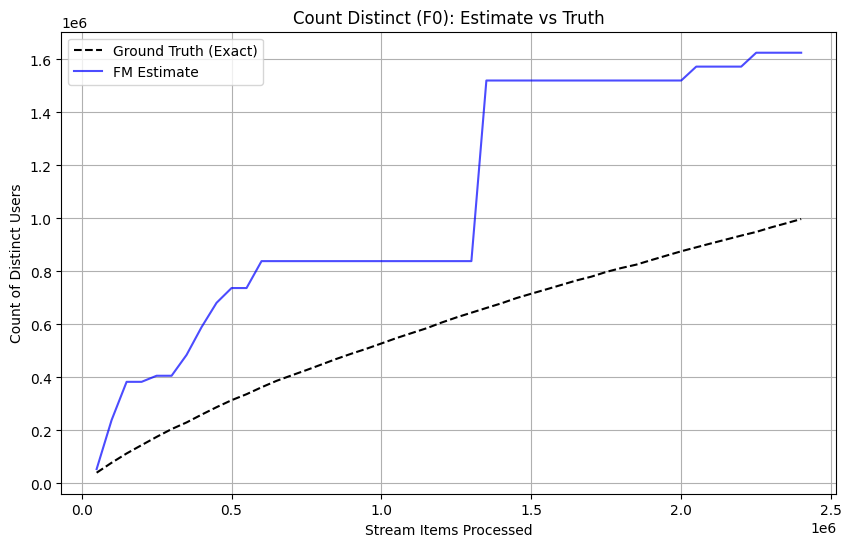

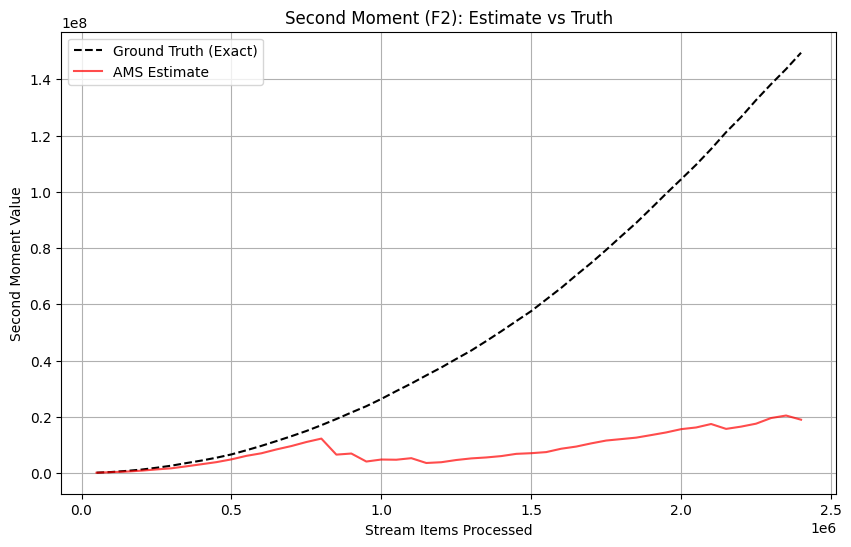

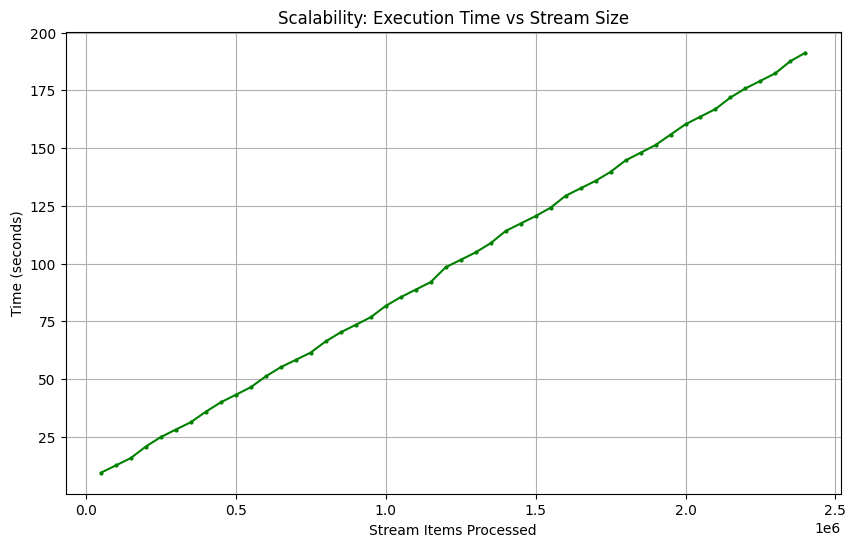

Plots saved as .png files. Download them from the files tab!


In [48]:
import matplotlib.pyplot as plt
import time
import numpy as np

# Initialize algorithms
fm_algo = FlajoletMartin(num_groups=25, hashes_per_group=5)
ams_algo = AMS_Estimator(num_variables=200)

# Ground truth storage
exact_counts = {}
stream_len = 0

# --- METRICS STORAGE ---
history_x = []          # Stream position (n)
history_fm_est = []     # F0 Estimate
history_fm_true = []    # F0 True
history_ams_est = []    # F2 Estimate
history_ams_true = []   # F2 True
timestamps = []         # For scalability analysis

start_time = time.time()
print(f"Starting Stream Processing...")

# Process the stream
# Note: Ensure DEBUG_MODE is False or DEBUG_LIMIT is high enough (e.g., 100k)
# to get good looking graphs.
stream = get_stream(DATA_FILE, limit=DEBUG_LIMIT if DEBUG_MODE else None)

for user_id in stream:
    stream_len += 1

    # 1. Update Stream Algorithms
    fm_algo.process(user_id)
    ams_algo.process(user_id)

    # 2. Update Ground Truth (Exact)
    if user_id in exact_counts:
        exact_counts[user_id] += 1
    else:
        exact_counts[user_id] = 1

# 3. Snapshot Metrics
    # We record Time and F0 often (fast operations)
    if stream_len % 1000 == 0:
        est_f0 = fm_algo.estimate()
        true_f0 = len(exact_counts) # Fast O(1)

        # F2 IS SLOW: Only calculate Ground Truth every 50k items
        # We perform a check to see if we should calculate F2, or just copy the previous value
        # (or skip plotting it for intermediate points)
        if stream_len % 50000 == 0:
            est_f2 = ams_algo.estimate()
            true_f2 = sum([c**2 for c in exact_counts.values()]) # <--- The bottleneck

            # Store all data points
            history_x.append(stream_len)
            history_fm_est.append(est_f0)
            history_fm_true.append(true_f0)
            history_ams_est.append(est_f2)
            history_ams_true.append(true_f2)
            timestamps.append(time.time() - start_time)

            # Optional: Print status to know it's alive
            print(f"Processed {stream_len} reviews... F0 Est: {est_f0}")

print("-" * 60)
print("Processing Complete. Generating Plots...")

# --- PLOTTING FOR REPORT ---

# 1. Flajolet-Martin Convergence Plot
plt.figure(figsize=(10, 6))
plt.plot(history_x, history_fm_true, label='Ground Truth (Exact)', color='black', linestyle='--')
plt.plot(history_x, history_fm_est, label='FM Estimate', color='blue', alpha=0.7)
plt.title('Count Distinct (F0): Estimate vs Truth')
plt.xlabel('Stream Items Processed')
plt.ylabel('Count of Distinct Users')
plt.legend()
plt.grid(True)
plt.savefig('f0_convergence.png') # Save for LaTeX
plt.show()

# 2. AMS Convergence Plot
plt.figure(figsize=(10, 6))
plt.plot(history_x, history_ams_true, label='Ground Truth (Exact)', color='black', linestyle='--')
plt.plot(history_x, history_ams_est, label='AMS Estimate', color='red', alpha=0.7)
plt.title('Second Moment (F2): Estimate vs Truth')
plt.xlabel('Stream Items Processed')
plt.ylabel('Second Moment Value')
plt.legend()
plt.grid(True)
plt.savefig('f2_convergence.png') # Save for LaTeX
plt.show()

# 3. Scalability (Time vs Input Size)
plt.figure(figsize=(10, 6))
plt.plot(history_x, timestamps, color='green', marker='o', markersize=2)
plt.title('Scalability: Execution Time vs Stream Size')
plt.xlabel('Stream Items Processed')
plt.ylabel('Time (seconds)')
plt.grid(True)
plt.savefig('scalability_time.png') # Save for LaTeX
plt.show()

print("Plots saved as .png files. Download them from the files tab!")